# CS 273P Final Project Notebook

## Project Topic - Classification of American Sign Language Letters using Convolutional Neural Networks

### Members - Yash Uday Kulkarni, Kenneth Tony Chungath

### This is a Kaggle kernel so it won't be executed on a normal machine. Please fork and run the Kaggle kernel to execute this notebook. 

### Link: https://www.kaggle.com/yashudaykulkarni/model-inference

### Link of Model: https://drive.google.com/file/d/1lQdHNOHApjlK2lRdfL0LRSUNYVkqDGmV/view?usp=sharing

In [1]:
!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.datasets.utils import download_file_from_google_drive
from torch import optim, cuda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchsummary import summary
import seaborn as sns
import torch.nn as nn
import torch
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image

## Downloading the model from Google Drive into Kaggle Kernel

In [3]:
file_id = "1lQdHNOHApjlK2lRdfL0LRSUNYVkqDGmV"
root = "/kaggle/working"
file_name = "vgg_cur_model_transfer_learning_2.pt"
download_file_from_google_drive(file_id, root, file_name)

In [4]:
index_to_char_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

In [5]:
image_transforms = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

In [6]:
#Parameters
dataset_1_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train' #Link: https://www.kaggle.com/grassknoted/asl-alphabet
dataset_2_dir = '../input/asl-alphabet-new-test/asl-alphabet-test' #Link: https://www.kaggle.com/yashudaykulkarni/asl-alphabet-new-test

img_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

save_file_name = '/kaggle/working/vgg_cur_model_transfer_learning_2.pt'

batch_size = 16
lr = 0.001
momentum = 0.9
epoch_stop_condition = 5
n_epochs = 5

dataset_1_length = 87000
dataset_2_length = 870

n_classes = 29

train_split_ratio = 0.5
val_split_ratio = 0.25

In [7]:
def load_model(model):
    device = torch.device('cpu')
    model.load_state_dict(torch.load(save_file_name, map_location=device))
    model.optimizer = optimizer

In [1]:
def get_predictions(img, model):

    probs = nn.Softmax(dim=1)
    
    img = img.unsqueeze(0)
    
    top5_classes = []
    
    with torch.no_grad():
        #Set the model to evaluation mode for calculating stats
        model.eval()

        #Calculate output of the model 
        output = model(img)
        softmax_output = probs(output)   
        
        #Calculate top 5 probabilities and labels of the output
        top5_probs, top5_label = torch.topk(softmax_output, 5)
        
        top5_probs_list = top5_probs.cpu().flatten().tolist()
        top5_label_list = top5_label.cpu().flatten().tolist()
        
        for elem in top5_label_list:
            top5_classes.append(index_to_char_map[elem])
            
        return top5_probs_list, top5_classes

In [9]:
def get_random_classes(count):
    random_classes_list = []
    
    random_classes_list = random.sample(range(29), count)
    
    return random_classes_list

In [10]:
def get_model(pretrained):
    if pretrained:
        model = models.vgg16_bn(pretrained=True)
    else:
        model = models.vgg16_bn()
    model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=29, bias=True)
                                    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    return model, criterion, optimizer

## Set up model object with weights

In [11]:
model, criterion, optimizer = get_model(False)

In [12]:
load_model(model)

## Show top 5 predictions for 4 random class images of the dataset

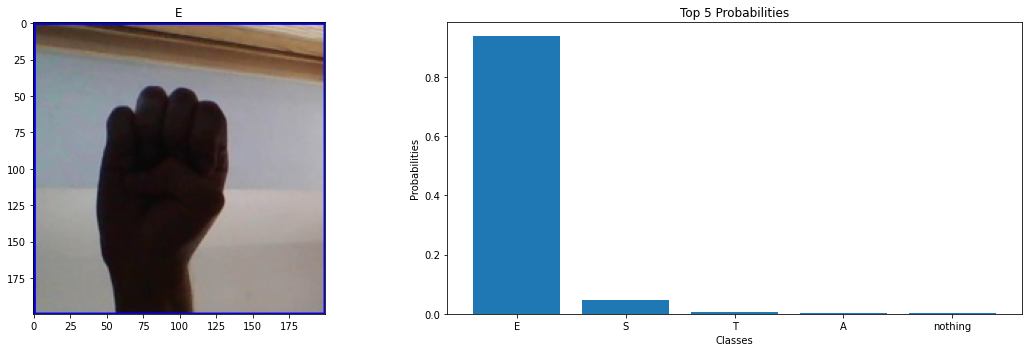

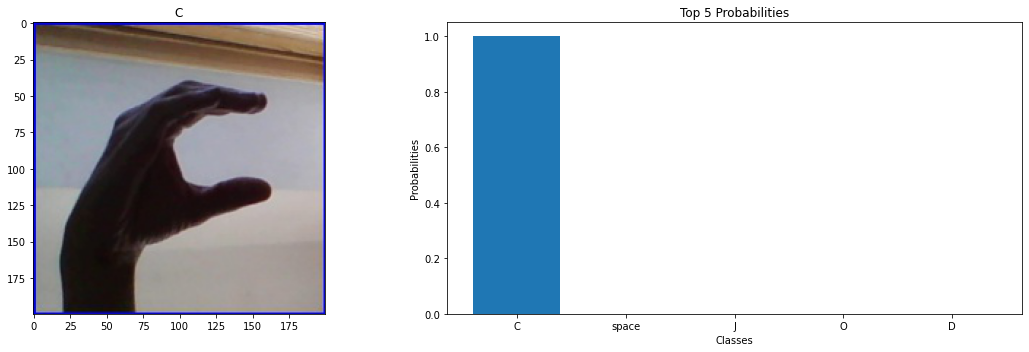

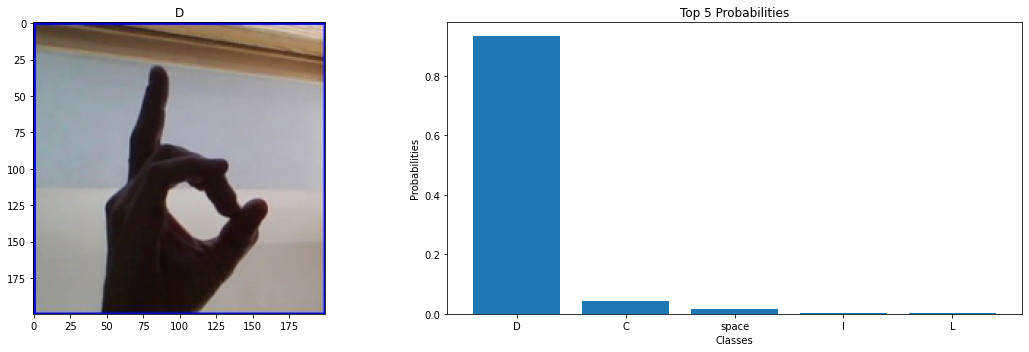

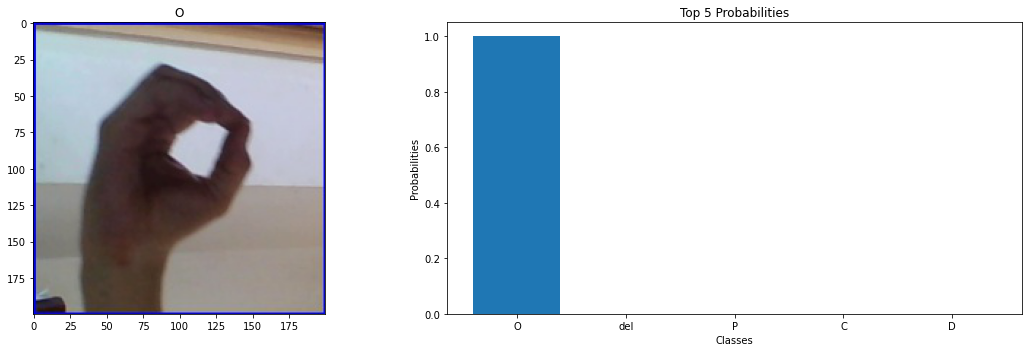

In [13]:
random_class_list = get_random_classes(4)

for value in random_class_list:
    value = index_to_char_map[value]
    if value != 'del':
        img = Image.open(img_dir + value + '_test.jpg')
        transformed_img = image_transforms(img)
        top5_prob, top5_label = get_predictions(transformed_img, model)
        
        plt.figure(figsize=(16, 5))
        
        ax = plt.subplot(1, 2, 1)
        ax.imshow(img)
        ax.set_title(value)
        
        ax = plt.subplot(1, 2, 2)
        ax.bar(top5_label, top5_prob)
        ax.set_title('Top 5 Probabilities')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Probabilities')
        
        plt.tight_layout()
        
        plt.savefig(value + '_graph.png')